<a href="https://colab.research.google.com/github/aimalz/CASTORpz/blob/main/TLM_redshift_and_color_evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

from astropy.table import Table
prepend = '/content/drive/MyDrive/Research/CASTORpz/'
unp = Table.read(prepend+"unperturbed_mags.fits")
print(len(unp))

# !pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install jaxlib==0.4.16
!pip install jax==0.4.16

# jaxlib==0.3.22+cuda11.cudnn82

# !pip install jax[cuda]==0.4.17+cuda12.cudnn89 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# !pip install "jax[cuda]"==0.4.16
!nvcc --version

!pip install astropy pzflow corner

from pzflow import Flow
import jax.numpy as jnp
import pandas as pd
import numpy as np
import pickle
import corner
import matplotlib.pyplot as plt
from astropy.table import Table
from pzflow import Flow, FlowEnsemble
from pzflow.distributions import Uniform
from pzflow.bijectors import Chain, StandardScaler, NeuralSplineCoupling, ColorTransform, InvSoftplus, RollingSplineCoupling, ShiftBounds

Mounted at /content/drive
698211
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 MB 9.7 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.26+cuda12.cudnn89
    Uninstalling jaxlib-0.4.26+cuda12.cudnn89:
      Successfully uninstalled jaxlib-0.4.26+cuda12.cudnn89
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.6 MB/s eta 0:00:00
  Attempting uninstall: jax
    Found existing installation: jax 0.4.26
    Uninstalling jax-0.4.26:
      Successfully uninstalled jax-0.4.26
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flax 0.8.4 requires jax>=0.4.19, but you have jax 0.4.16 which is incompatible.
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
 

In [3]:
cd /content/drive/MyDrive/Research/CASTORpz


/content/drive/MyDrive/Research/CASTORpz


In [4]:
unp = Table.read(prepend+"unperturbed_mags.fits").to_pandas()#.set_index('ID')
mock = Table.read(prepend+"ext_phot.fits").to_pandas()#.set_index('ID')

In [5]:
names_phot = ["ID", "photoz",
              "LSST_u_MAG",
              "LSST_g_MAG", "LSST_g_MAGERR",
              "LSST_r_MAG", "LSST_r_MAGERR",
              "LSST_i_MAG", "LSST_i_MAGERR",
              "LSST_z_MAG", "LSST_z_MAGERR",
              "castor_uv_MAG", "castor_uv_MAGERR",
              "castor_u_MAG", "castor_u_MAGERR",
              "castor_g_MAG", "castor_g_MAGERR",
              "Euclid_VIS_MAG",
              'Euclid_Y_MAG','Euclid_J_MAG','Euclid_H_MAG',
              'Roman_106_MAG',
              'Roman_129_MAG','Roman_158_MAG',
              'Roman_184_MAG']



available_os = ["CASTOR-only", "LSST-only", "Euclid-only", #"Roman-only",
"LSST+CASTOR", "Euclid+CASTOR", #"Roman+CASTOR",
"Euclid+LSST", "Euclid+LSST+CASTOR"
]

Roman_os = ["Roman-only", "Roman+CASTOR", "Roman+Euclid+LSST+CASTOR", "Roman+LSST"]

available_os = available_os + Roman_os
print(available_os)

names = available_os

['CASTOR-only', 'LSST-only', 'Euclid-only', 'LSST+CASTOR', 'Euclid+CASTOR', 'Euclid+LSST', 'Euclid+LSST+CASTOR', 'Roman-only', 'Roman+CASTOR', 'Roman+Euclid+LSST+CASTOR', 'Roman+LSST']


In [6]:
# load data
def getTrueY(test_cat, mag_col_names, y_col_name):
    test_cat = Table(test_cat, masked=True, copy=True)
    # remove nans
    for col in mag_col_names:
        test_cat[col].mask = np.isnan(test_cat[col].data) | test_cat[col].mask
        test_cat = test_cat[~test_cat[col].mask] # then remove nans from test set

    true_y = test_cat[y_col_name]
    return true_y.filled()

In [7]:
available_os = ['LSST-only',
                'CASTOR-only',
                'Euclid+LSST',
                'LSST+CASTOR',
                'Roman+Euclid+LSST',
                'Roman+Euclid+LSST+CASTOR']

os_combo_labels = {'LSST-only': 'LSST',
                  'CASTOR-only': 'CASTOR',
                  'LSST+CASTOR': 'LSST+CASTOR',
                  'Roman+LSST': 'LSST+Roman',
                  # 'Roman+LSST+CASTOR' : 'LSST+Roman+CASTOR', #(currently training, will be in Mar_experiments)
                  'Roman+Euclid+LSST': 'LSST+Roman+Euclid',
                  'Roman+Euclid+LSST+CASTOR': 'LSST+Roman+Euclid+CASTOR'}

In [ ]:
# tav_cats = {}
# just_tav = {}
# for os in available_os:
#   # print(os)
#   with (open(f"{os}_with_tav.pkl", 'rb')) as openfile:
#     tav_cats[os] = pd.read_pickle(openfile)
#     # print(tav_cats[os].columns)
#     just_tav[os] = tav_cats[os]['log_prob']

FileNotFoundError: [Errno 2] No such file or directory: 'CASTOR-only_with_tav.pkl'

In [ ]:
# [(tav_cats['LSST-only']['z_true'] > 1.5) & (tav_cats['LSST-only']['z_true'] < 2.25)]

[CASTOR_ID
 1          True
 2         False
 3         False
 5         False
 12        False
           ...  
 964428    False
 964429    False
 964437     True
 964439    False
 964449    False
 Name: z_true, Length: 430635, dtype: bool]

In [ ]:
# just_tav['LSST-only'][(tav_cats['LSST-only']['z_true'] > 1.5) & (tav_cats['LSST-only']['z_true'] < 2.25) & tav_cats['LSST-only']['z_true'] < 2.25)]

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (<ipython-input-12-cefc52ac1198>, line 1)

In [ ]:
# u-band cuts on just_tav - 30, 38, 45 second exposures
# distribution of these values
# plot the CDF


In [ ]:
# ls reruns_of_old_catalogs/

losses_for_LSST-only.pkl  pzflow_ensemble_for_LSST-only_z15to225.pkl


In [ ]:
# flows = FlowEnsemble(file=f"reruns_of_old_catalogs/pzflow_ensemble_for_LSST-only_z15to225.pkl")

In [11]:
mock_cat = pd.merge(mock, unp[['ID',"Euclid_VIS_MAG"]], on='ID')
CASTOR_baseline = Table.from_pandas(mock_cat)

In [29]:
# put data in expected format for TLM

LSST_u_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_u_MAG")
LSST_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAG")
LSST_r_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAG")
LSST_i_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAG")
LSST_z_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAG")
LSST_y_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_y_MAG")

# LSST_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAGERR")
# LSST_r_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAGERR")
# LSST_i_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAGERR")
# LSST_z_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAGERR")

CASTOR_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAG")
CASTOR_u_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAG")
CASTOR_uv_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAG")

# CASTOR_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAGERR")
# CASTOR_u_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAGERR")
# CASTOR_uv_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAGERR")

Euclid_VIS_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_VIS_MAG")
Euclid_J_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_J_MAG")
Euclid_H_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_H_MAG")
Euclid_Y_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_Y_MAG")

# Roman - only a subset of the Roman filters are available?

# Roman_062_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_062_MAG')
# Roman_087_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_087_MAG')
Roman_106_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_106_MAG')

Roman_129_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_129_MAG')
# Roman_146_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_146_MAG')
Roman_158_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_158_MAG')

Roman_184_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_184_MAG')
# Roman_213_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_213_MAG')

ID = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="ID")
z_true = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="photoz")

In [33]:
which_cols = {}
which_cols['LSST'] = {'r': LSST_r_mag,
                             'u-g': LSST_u_mag - LSST_g_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'z-y': LSST_z_mag - LSST_y_mag,
                      }
which_cols['CASTOR'] = {'g': CASTOR_g_mag,
                             'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
                             'u-g': CASTOR_u_mag - CASTOR_g_mag}
which_cols['Roman'] = {'106': Roman_106_mag,
                             '129 - 106': Roman_129_mag - Roman_106_mag,
                             '158-129': Roman_158_mag - Roman_129_mag,
                             '184-158': Roman_184_mag - Roman_158_mag}
which_cols['Euclid'] = { 'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag,
                             'y-j': Euclid_Y_mag - Euclid_J_mag,
                             'j-h': Euclid_J_mag - Euclid_H_mag}

In [34]:
test_catalogs = {}
test_catalogs['LSST-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST']}).set_index('CASTOR_ID').dropna()
test_catalogs['CASTOR-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid']}).set_index('CASTOR_ID').dropna()
test_catalogs['LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Euclid']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Roman']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+Roman'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['Roman']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Roman'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+Euclid+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['Roman'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+Euclid+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['Roman'], **which_cols['LSST']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+Euclid+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman'], **which_cols['LSST'], **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()

In [59]:
available_os = list(test_catalogs.keys())

flows = {}
for os in available_os:
  flows[os] = FlowEnsemble(file=f"June_1_runs/pzflow_ensemble_for_{os}.pkl")

In [43]:
from scipy import stats

In [118]:
catalogs = {}

for os in available_os:
  catalogs[os] = test_catalogs[os][(np.abs(stats.zscore(test_catalogs[os])) < 3).all(axis=1)]

In [119]:
tav = {}
for os in available_os:
  print(os)
  tav[os] = flows[os].log_prob(catalogs[os], returnEnsemble = True)

LSST-only
CASTOR-only
Roman-only
Euclid-only
LSST+CASTOR
Euclid+CASTOR
Roman+CASTOR


KeyboardInterrupt: 

In [9]:
# mock_cat = pd.merge(mock, unp[['ID',"Euclid_VIS_MAG"]], on='ID')

# CASTOR_baseline = Table.from_pandas(mock_cat[(mock_cat["Euclid_VIS_MAG"] <= 24.5) & (mock_cat["LSST_r_MAG"] >= 17.5)]) # apply magnitude limit cuts
# CASTOR_baseline = Table.from_pandas(mock_cat) # apply magnitude limit cuts

In [10]:
# # put data in expected format for TLM

# LSST_u_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_u_MAG")
# LSST_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAG")
# LSST_r_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAG")
# LSST_i_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAG")
# LSST_z_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAG")
# LSST_y_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_y_MAG")


# # LSST_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAGERR")
# # LSST_r_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAGERR")
# # LSST_i_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAGERR")
# # LSST_z_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAGERR")

# CASTOR_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAG")
# CASTOR_u_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAG")
# CASTOR_uv_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAG")

# # CASTOR_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAGERR")
# # CASTOR_u_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAGERR")
# # CASTOR_uv_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAGERR")

# Euclid_VIS_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_VIS_MAG")
# Euclid_J_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_J_MAG")
# Euclid_H_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_H_MAG")
# Euclid_Y_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_Y_MAG")

# # Roman - only a subset of the Roman filters are available?

# # Roman_062_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_062_MAG')
# # Roman_087_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_087_MAG')
# Roman_106_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_106_MAG')

# Roman_129_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_129_MAG')
# # Roman_146_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_146_MAG')
# Roman_158_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_158_MAG')

# Roman_184_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_184_MAG')
# # Roman_213_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_213_MAG')

# ID = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="ID")
# z_true = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="photoz")

In [ ]:
# # get magnitudes and set up the catalogs

# catalogs = dict()
# catalogs['LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                              'r': LSST_r_mag,
#                              'g-r': LSST_g_mag - LSST_r_mag,
#                              'r-i': LSST_r_mag - LSST_i_mag,
#                              'i-z': LSST_i_mag - LSST_z_mag,
#                              'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
#                              'u-g': CASTOR_u_mag - CASTOR_g_mag
#                       }).set_index('CASTOR_ID').dropna()
# catalogs['LSST-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                              'r': LSST_r_mag,
#                              'g-r': LSST_g_mag - LSST_r_mag,
#                              'r-i': LSST_r_mag - LSST_i_mag,
#                              'i-z': LSST_i_mag - LSST_z_mag
#                       }).set_index('CASTOR_ID').dropna()
# catalogs['CASTOR-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                              'g': CASTOR_g_mag,
#                              'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
#                              'u-g': CASTOR_u_mag - CASTOR_g_mag
#                       }).set_index('CASTOR_ID').dropna()
# catalogs['Euclid-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                              'v': Euclid_VIS_mag,
#                              'v-y': Euclid_VIS_mag - Euclid_Y_mag,
#                              'y-j': Euclid_Y_mag - Euclid_J_mag,
#                              'j-h': Euclid_J_mag - Euclid_H_mag
#                       }).set_index('CASTOR_ID').dropna()

# catalogs['Euclid+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                              'g': CASTOR_g_mag,
#                              'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
#                              'u-g': CASTOR_u_mag - CASTOR_g_mag,
#                              'v': Euclid_VIS_mag,
#                              'v-y': Euclid_VIS_mag - Euclid_Y_mag,
#                              'y-j': Euclid_Y_mag - Euclid_J_mag,
#                              'j-h': Euclid_J_mag - Euclid_H_mag
#                       }).set_index('CASTOR_ID').dropna()
# catalogs['Euclid+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                               'r': LSST_r_mag,
#                              'g-r': LSST_g_mag - LSST_r_mag,
#                              'r-i': LSST_r_mag - LSST_i_mag,
#                              'i-z': LSST_i_mag - LSST_z_mag,
#                              'v': Euclid_VIS_mag,
#                              'v-y': Euclid_VIS_mag - Euclid_Y_mag,
#                              'y-j': Euclid_Y_mag - Euclid_J_mag,
#                              'j-h': Euclid_J_mag - Euclid_H_mag
#                       }).set_index('CASTOR_ID').dropna()
# catalogs['Euclid+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                               'r': LSST_r_mag,
#                              'g-r': LSST_g_mag - LSST_r_mag,
#                              'r-i': LSST_r_mag - LSST_i_mag,
#                              'i-z': LSST_i_mag - LSST_z_mag,
#                              'v': Euclid_VIS_mag,
#                              'v-y': Euclid_VIS_mag - Euclid_Y_mag,
#                              'y-j': Euclid_Y_mag - Euclid_J_mag,
#                              'j-h': Euclid_J_mag - Euclid_H_mag,
#                              'g': CASTOR_g_mag,
#                              'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
#                              'u-g': CASTOR_u_mag - CASTOR_g_mag
#                       }).set_index('CASTOR_ID').dropna()

# catalogs["Roman+Euclid+LSST+CASTOR"] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                              'r': LSST_r_mag,
#                              'g-r': LSST_g_mag - LSST_r_mag,
#                              'r-i': LSST_r_mag - LSST_i_mag,
#                              'i-z': LSST_i_mag - LSST_z_mag,
#                              'v': Euclid_VIS_mag,
#                              'v-y': Euclid_VIS_mag - Euclid_Y_mag,
#                              'y-j': Euclid_Y_mag - Euclid_J_mag,
#                              'j-h': Euclid_J_mag - Euclid_H_mag,
#                              'g': CASTOR_g_mag,
#                              'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
#                              'u-g': CASTOR_u_mag - CASTOR_g_mag,
#                              '106': Roman_106_mag,
#                              '129 - 106': Roman_129_mag - Roman_106_mag,
#                              '158-129': Roman_158_mag - Roman_129_mag,
#                              '184-158': Roman_184_mag - Roman_158_mag
#                       }).set_index('CASTOR_ID').dropna()

# catalogs["Roman+Euclid+LSST"] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
#                              'r': LSST_r_mag,
#                              'g-r': LSST_g_mag - LSST_r_mag,
#                              'r-i': LSST_r_mag - LSST_i_mag,
#                              'i-z': LSST_i_mag - LSST_z_mag,
#                              'v': Euclid_VIS_mag,
#                              'v-y': Euclid_VIS_mag - Euclid_Y_mag,
#                              'y-j': Euclid_Y_mag - Euclid_J_mag,
#                              'j-h': Euclid_J_mag - Euclid_H_mag,
#                              '106': Roman_106_mag,
#                              '129 - 106': Roman_129_mag - Roman_106_mag,
#                              '158-129': Roman_158_mag - Roman_129_mag,
#                              '184-158': Roman_184_mag - Roman_158_mag
#                       }).set_index('CASTOR_ID').dropna()

In [56]:

# available_os = ['LSST-only',
#                 'CASTOR-only',
#                 'Euclid+LSST',
#                 'LSST+CASTOR',
#                 'Roman+Euclid+LSST',
#                 'Roman+Euclid+LSST+CASTOR']

# tav = {}
# for os in available_os:
#   tav[os] = flows[os].log_prob(catalogs[os])

In [ ]:
# tav[]

**Dropping bad flows here**

In [ ]:
losses = {}
for os in available_os:
  with (open(f"losses_for_{os}.pkl", 'rb')) as openfile:
    losses[os] = pd.read_pickle(openfile)

In [ ]:
flow_list = list(np.linspace(0, 29, 30).astype(int))
bad_flows = {}

for os in available_os:
  bad_flows_list = []
  for flow in flow_list:
    if np.sum(np.isinf(np.array(losses[os]['losses'][f"Flow {flow}"]))) > 0:
      bad_flows_list.append(flow)
    bad_flows[os] = bad_flows_list

In [ ]:
bad_flows

{'LSST-only': [8, 17, 20],
 'CASTOR-only': [3, 13, 16],
 'Euclid+LSST': [2, 8, 9, 13],
 'LSST+CASTOR': [25, 28],
 'Roman+Euclid+LSST': [2, 5, 14, 16, 19],
 'Roman+Euclid+LSST+CASTOR': [7, 15]}

In [ ]:
just_tav_ensemble = {}
for os in available_os:
  just_tav_ensemble[os] = flows[os].log_prob(catalogs[os], returnEnsemble = True)

In [ ]:
new_tav = {}

for os in available_os:
  new_tav[os] = np.delete(just_tav_ensemble[os], bad_flows[os], axis = 1)

In [ ]:
for os in available_os:
  print(new_tav[os].shape)

(108330, 27)
(108330, 27)
(108330, 26)
(108330, 28)
(108330, 25)
(108330, 28)


**Redshift Binned Plots**

In [50]:
import scipy.stats as sps

In [51]:
available_os

['LSST-only',
 'CASTOR-only',
 'Roman-only',
 'Euclid-only',
 'LSST+CASTOR',
 'Euclid+CASTOR',
 'Roman+CASTOR',
 'Euclid+LSST',
 'Roman+LSST',
 'Euclid+Roman',
 'Roman+LSST+CASTOR',
 'Roman+Euclid+CASTOR',
 'Euclid+LSST+CASTOR',
 'Roman+Euclid+LSST',
 'Roman+Euclid+LSST+CASTOR']

In [69]:
def compute_milb(just_tav, available_os):

  all_tlm = {}
  all_milb = {}
  all_ent = {}
  is_inf_mask = {}

  print(available_os)

  for os in available_os:
      # print(os_names[os])
      # load the photometric catalog for this os
    cat = catalogs[os]
    # print(cat.shape)

    # Computing the entropy H(z)
    b = sps.mstats.mquantiles(z_true, np.linspace(0,1,101, endpoint=True))

    pz = sps.rv_histogram(np.histogram(z_true, bins=b))
    entropy = pz.entropy()
    # just checking that this isn't discrete entropy and that binning doesn't need to match anything else
    # testent = sum(-1 * pz.logpdf(b_centers) * pz.pdf(b_centers) * db)
    # print(entropy - testent)
    all_ent[os] = entropy


    # Computing lower bound
    # all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
    milb = just_tav[os]
    # print(np.sum(np.isinf(milb)))
    # print(np.sum(np.isnan(milb)))
    # print(np.shape(milb[0,:]))
      # print(milb)
    all_milb[os] = np.array(milb)
      # print(np.shape(all_milb[os]))
    all_tlm[os] = milb.mean(axis=1) + entropy
    is_inf_mask[os] = np.isinf(all_tlm[os])
    all_tlm[os] = all_tlm[os][~np.isinf(all_tlm[os])]
    # print(np.sum(np.isinf(all_tlm[os])))

    # print('shape is: ')
    # print(np.shape(all_tlm[os]))
  return all_tlm, is_inf_mask

In [107]:
# entropy term

def bin_in_redshift(all_tlm, inf_mask):
  zbins = np.linspace(0, 3, 100)
  avgtav = {}
  errtav = {}
  # for os in available_os:
  for os in ['LSST-only']:
    print(os)
    plotran = np.empty_like(zbins)
    ploterr = np.empty_like(zbins)
    # print(catalogs[os].columns)
    # print(np.shape(catalogs[os]))

    if 'logprob' not in catalogs[os].columns.values:
      catalogs[os] = catalogs[os][~inf_mask[os]]
      catalogs[os]['logprob'] = all_tlm[os]

      # print(catalogs[os].columns)

      # print('shape is: ')

      # print(np.shape(catalogs[os]))

    print(all_tlm[os])
    for i, zmin in enumerate(zbins[:-1]):
      zmax = zbins[i+1]
      print(zmax)
      subset = catalogs[os][(catalogs[os]['z_true'] >= zmin) & (catalogs[os]['z_true'] < zmax)]
      # print((zmin, len(subset), zmax))
      vals = subset['logprob']
      mean = np.mean(subset['logprob'])
      # mean = np.mean(vals[vals >   -3])
      # print(mean)
      # std = np.std(vals[vals > -3])
      std = np.std(subset['logprob'])
      plotran[i] = mean
      ploterr[i] = std #len(vals))

    avgtav[os] = plotran
    errtav[os] = ploterr

  return avgtav, errtav

In [117]:
# (catalogs['LSST-only']['z_true'] <= zmax)
# catalogs['LSST-only']['z_true']

In [116]:
# zmin = 0.03
# zmax = 1
# print(catalogs['LSST-only'][(catalogs['LSST-only']['z_true'] <= zmax)]) # & (catalogs['LSST-only']['z_true'] < zmax)])
# print(catalogs['LSST-only'][(catalogs['LSST-only']['z_true'] >= zmin) & (catalogs['LSST-only']['z_true'] < zmax)])

In [108]:
all_tlm, is_inf_mask = compute_milb(tav, available_os)

avgtav, errtav = bin_in_redshift(all_tlm, is_inf_mask)

['LSST-only', 'CASTOR-only', 'Roman-only', 'Euclid-only', 'LSST+CASTOR', 'Euclid+CASTOR', 'Roman+CASTOR', 'Euclid+LSST', 'Roman+LSST', 'Euclid+Roman', 'Roman+LSST+CASTOR', 'Roman+Euclid+CASTOR', 'Euclid+LSST+CASTOR', 'Roman+Euclid+LSST', 'Roman+Euclid+LSST+CASTOR']


<ipython-input-69-487db431c255>:19: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


LSST-only
[1.1192241 3.8704262 2.4647105 ... 3.6721601 2.3291974 2.799485 ]
0.030303030303030304
0.06060606060606061
0.09090909090909091
0.12121212121212122
0.15151515151515152
0.18181818181818182
0.21212121212121213
0.24242424242424243
0.2727272727272727
0.30303030303030304
0.33333333333333337
0.36363636363636365
0.3939393939393939
0.42424242424242425
0.4545454545454546
0.48484848484848486
0.5151515151515151
0.5454545454545454
0.5757575757575758
0.6060606060606061
0.6363636363636364
0.6666666666666667
0.696969696969697
0.7272727272727273
0.7575757575757576
0.7878787878787878
0.8181818181818182
0.8484848484848485
0.8787878787878788
0.9090909090909092
0.9393939393939394
0.9696969696969697
1.0
1.0303030303030303
1.0606060606060606
1.0909090909090908
1.1212121212121213
1.1515151515151516
1.1818181818181819
1.2121212121212122
1.2424242424242424
1.2727272727272727
1.303030303030303
1.3333333333333335
1.3636363636363638
1.393939393939394
1.4242424242424243
1.4545454545454546
1.48484848484848

In [98]:
avgtav

{'LSST-only': array([        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,     

0
nan
0
nan
0
nan
0
nan
0
nan
0
nan
0
nan
0
nan
0
nan
0
nan
0
nan
0
nan
0
nan
0
nan
0
nan


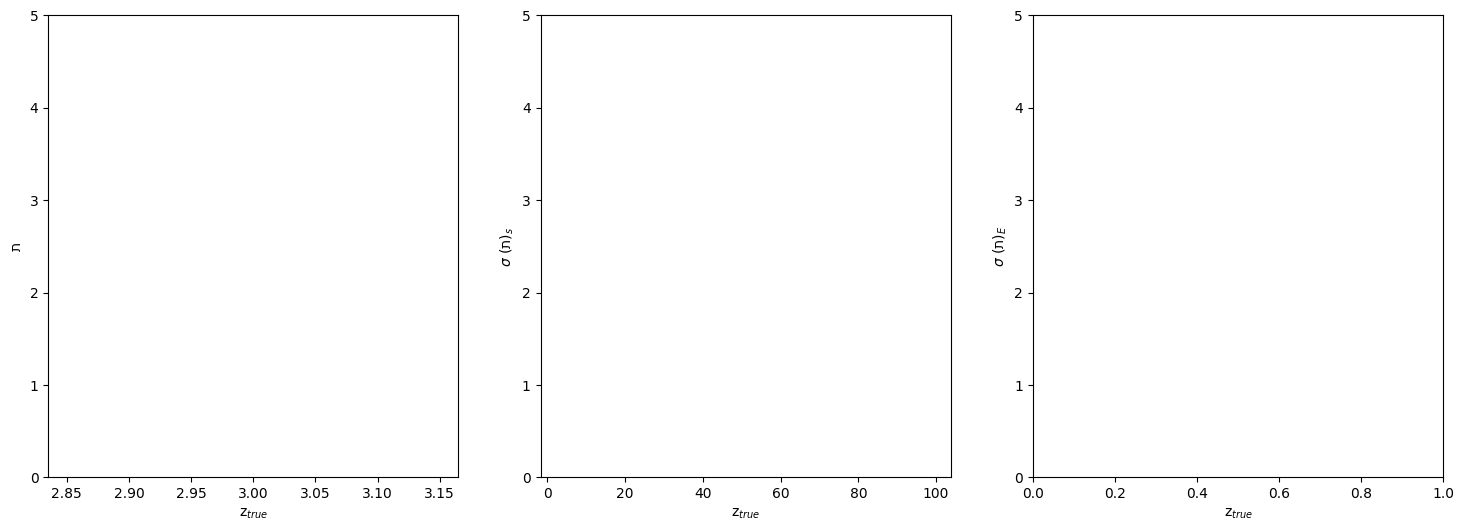

In [73]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

zbins = np.linspace(0, 3, 100)


for os in available_os:
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.7)
  ax[1].plot(zbins, errtav[os], errtav[os], alpha = 0.7)
  # ax[2].plot(zbins, binned_variance[os], label =os, alpha = 0.7)

# ax[0].set_ylim(-10, 5)
# ax[0].legend(fontsize = 8)
ax[0].set_xlabel('z$_{true}$')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(0, 5)

# ax[0].legend(fontsize = 8)
ax[1].set_xlabel('z$_{true}$')
ax[1].set_ylabel('$\sigma$ (' + chr(0x05ea) +')$_s$')
ax[1].set_ylim(0, 5)

ax[2].set_ylabel('$\sigma$ (' + chr(0x05ea) +')$_E$')
ax[2].set_xlabel('z$_{true}$')
ax[2].set_ylim(0, 5)

plt.savefig('redshift_binned_with_uncertainty_same_scales.png')


# ax[0].set_ylim(-2, 5)

In [ ]:
def compute_milb_ensemble(just_tav, available_os):

  all_tlm = {}
  all_milb = {}
  all_ent = {}
  is_inf_mask = {}

  print(available_os)

  for os in available_os:
      # print(os_names[os])
      # load the photometric catalog for this os
    cat = catalogs[os]
    # print(cat.shape)

    # Computing the entropy H(z)
    b = sps.mstats.mquantiles(z_true, np.linspace(0,1,101, endpoint=True))

    pz = sps.rv_histogram(np.histogram(z_true, bins=b))
    entropy = pz.entropy()
    # just checking that this isn't discrete entropy and that binning doesn't need to match anything else
    # testent = sum(-1 * pz.logpdf(b_centers) * pz.pdf(b_centers) * db)
    # print(entropy - testent)
    all_ent[os] = entropy


    # Computing lower bound
    # all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
    milb = just_tav[os]
    # print(np.sum(np.isinf(milb)))
    # print(np.sum(np.isnan(milb)))
    # print(np.shape(milb[0,:]))
      # print(milb)
    all_milb[os] = np.array(milb)
      # print(np.shape(all_milb[os]))
    all_tlm[os] = all_milb[os] + entropy
    is_inf_mask[os] = np.isinf(all_tlm[os])
    # all_tlm[os] = all_tlm[os][~np.isinf(all_tlm[os])]
    # print(np.sum(np.isinf(all_tlm[os])))

    # print('shape is: ')
    # print(np.shape(all_tlm[os]))
  return all_tlm, is_inf_mask

In [ ]:
all_tlm, is_inf_mask = compute_milb_ensemble(new_tav, available_os)


['LSST-only', 'CASTOR-only', 'Euclid+LSST', 'LSST+CASTOR', 'Roman+Euclid+LSST', 'Roman+Euclid+LSST+CASTOR']


<ipython-input-55-2c69b1faeef8>:19: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


In [ ]:
np.shape(all_tlm['LSST-only'])

(108330, 27)

In [ ]:
type(all_tlm['LSST-only'])

numpy.ndarray

In [ ]:
import numpy.ma as ma

In [ ]:
epistemic_variance = {}
redshifts = {}

for os in available_os:
  epistemic_variance[os] = ma.array(all_tlm[os], mask = ~(np.abs(all_tlm[os]) < 100)).std(axis=1).data
  redshifts[os] = ma.array(catalogs[os]['z_true'], mask = ~(np.abs(all_tlm[os].mean()) < 100)).data

In [ ]:
binned_variance = {}

for os in available_os:
  print(epistemic_variance[os].shape)
  print(redshifts[os].shape)

  ploterr = np.empty_like(zbins)
  for i, zmin in enumerate(zbins[:-1]):
      zmax = zbins[i+1]
      ploterr[i] = np.mean(epistemic_variance[os][(redshifts[os] >=zmin) & (redshifts[os] < zmax)])

      binned_variance[os] = ploterr



(108330,)
(108330,)
(108330,)
(108330,)
(108330,)
(108330,)
(108330,)
(108330,)
(108330,)
(108330,)
(108330,)
(108330,)


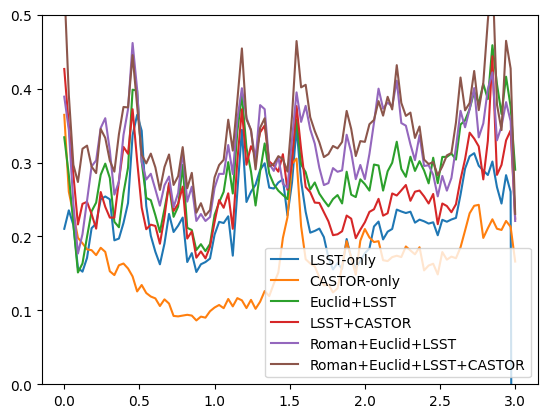

In [ ]:
for os in available_os:
  plt.plot(zbins, binned_variance[os], label = os)
  plt.ylim(0, 0.5)

  plt.legend()

possibly a consequence of weird values in the catalogs --> more surveys compounds this effect. "Mo surveys, mo problems" - Alex Malz

different surveys use different placeholders for bad values --> as you combine surveys, how many notions --> value of bad values --> coherent surveys, how do notions of bad values impact survey metrics --> good sample size gets smaller with more surveys

In [ ]:
redshifts['LSST-only'].shape

(430635,)

In [ ]:
a = np.array(catalogs[os]['z_true'])

In [ ]:
np.repeat(np.array(catalogs[os]['z_true'])[:, np.newaxis], 27, axis=1)

(430635, 27)

In [ ]:

for os in available_os:
    ploterr = np.empty_like(zbins)
    # catalogs[os] = catalogs[os][(np.abs(all_tlm[os]) < 100)]

    for i, zmin in enumerate(zbins[:-1]):
      zmax = zbins[i+1]
      # subset = epistemic_variance[os][(catalogs[os]['z_true'] >= zmin) & (catalogs[os]['z_true'] < zmax)]

      subset = ma.array(all_tlm[os], mask = ~(np.abs(all_tlm[os]) < 100) & (np.repeat(np.array(catalogs[os]['z_true'])[:, np.newaxis], 27, axis=1) >= zmin) & (np.repeat(np.array(catalogs[os]['z_true'])[:, np.newaxis], 27, axis=1) < zmax)).std(axis=1).data

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


ValueError: operands could not be broadcast together with shapes (430635,26) (430635,27) 

In [ ]:
def bin_in_redshift(all_tlm, inf_mask):
  zbins = np.linspace(0, 3, 100)
  avgtav = {}
  errtav = epistemic_variance
  for os in available_os:
    print(os)
    plotran = np.empty_like(zbins)
    ploterr = np.empty_like(zbins)
    # print(catalogs[os].columns)
    # print(np.shape(catalogs[os]))

    if 'logprob' not in catalogs[os].columns.values:
      catalogs[os] = catalogs[os][~inf_mask[os]]
      catalogs[os]['logprob'] = all_tlm[os]
      print(catalogs[os].columns)

      print('shape is: ')

      print(np.shape(catalogs[os]))
    for i, zmin in enumerate(zbins[:-1]):
      zmax = zbins[i+1]
      subset = catalogs[os][(catalogs[os]['z_true'] >= zmin) & (catalogs[os]['z_true'] < zmax)]
      # print((zmin, len(subset), zmax))
      vals = subset['logprob']
      mean = np.mean(vals[vals >   -3])
      # print(mean)
      std = np.std(vals[vals > -3])
      plotran[i] = mean
      ploterr[i] = std #len(vals))

    avgtav[os] = plotran
    errtav[os] = ploterr

  return avgtav, errtav

(430635,)

In [ ]:
A = np.array([[1, 2], [3, np.inf]])
A

~np.isfinite(all_tlm['LSST-only']) & (np.abs(all_tlm['LSST-only']) < 100)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
ma.array(A, mask = ~np.isfinite(A)).std()

0.816496580927726

In [ ]:
import numpy.ma as ma

In [ ]:
def compute_milb_stats(just_tav, available_os):

  all_tlm = {}
  all_milb = {}
  all_ent = {}
  is_inf_mask = {}

  new_tlm = {}
  std_tlm = {}

  print(available_os)

  for os in available_os:

    # Computing the entropy H(z)
    b = sps.mstats.mquantiles(z_true, np.linspace(0,1,101, endpoint=True))

    pz = sps.rv_histogram(np.histogram(z_true, bins=b))
    entropy = pz.entropy()
    # just checking that this isn't discrete entropy and that binning doesn't need to match anything else
    # testent = sum(-1 * pz.logpdf(b_centers) * pz.pdf(b_centers) * db)
    # print(entropy - testent)
    all_ent[os] = entropy

    # Computing lower bound
    # all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
    milb = just_tav[os]

    print(np.shape(milb))


    # print(np.sum(np.isinf(milb)))
    # print(np.sum(np.isnan(milb)))
    # print(np.shape(milb[0,:]))
      # print(milb)
    all_milb[os] = np.array(milb)
      # print(np.shape(all_milb[os]))
    all_tlm[os] = milb + entropy

    standards = []

    for i in range(0, np.shape(all_tlm[os])[1]):

      standards.append(np.std(all_tlm[os][:,i][np.isfinite(all_tlm[os][:,i])]))

      std_tlm[os] = standards

    # all_tlm_std = all_tlm[os].std(axis=1, where = ~np.isinf(all_tlm[os]))

  return std_tlm

In [ ]:

std_tlm = compute_milb_stats(new_tav, available_os)


['LSST-only', 'CASTOR-only', 'Euclid+LSST', 'LSST+CASTOR', 'Roman+Euclid+LSST', 'Roman+Euclid+LSST+CASTOR']
(430635, 27)


<ipython-input-359-c1c8f712d9b6>:18: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


(430635, 27)
(430635, 26)
(430635, 28)
(430635, 25)
(430635, 28)


In [ ]:
std_tlm['LSST-only']

[inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf]

In [ ]:
np.max(all_tlm_std)

inf

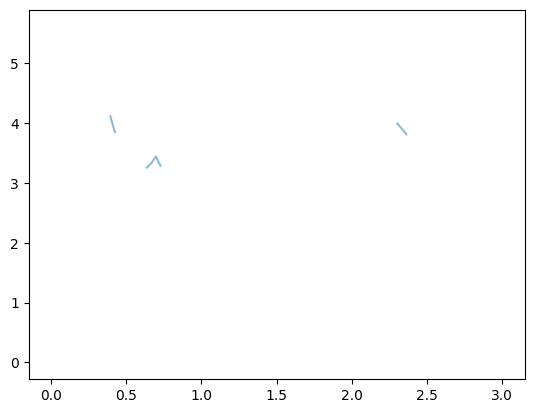

In [ ]:
for os in available_os:
  vals = np.zeros_like(zbins)

  for i, zmin in enumerate(zbins[:-1]):
    zmax = zbins[i+1]

    subset = all_tlm_std[(z_true > zmin) & (z_true < zmax)]
    vals[i] = np.mean(subset)

plt.plot(zbins, vals, label=os, alpha=0.5)


In [ ]:
vals

array([5.61689091,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
       4.29682207,        inf,        inf, 4.11501408, 3.84934044,
              inf,        inf,        inf,        inf,        inf,
              inf, 3.25604939, 3.33084249, 3.44355536, 3.28679085,
              inf,        inf, 3.36345959,        inf,        inf,
       3.04792452,        inf,        inf,        inf,        inf,
       3.72727346,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf, 3.65883517,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf, 4.26099634,        

In [ ]:
def bin_in_redshift(all_tlm, inf_mask):
  zbins = np.linspace(0, 3, 100)
  avgtav = {}
  errtav = {}
  for os in available_os:
    print(os)
    plotran = np.empty_like(zbins)
    ploterr = np.empty_like(zbins)
    # print(catalogs[os].columns)
    # print(np.shape(catalogs[os]))

    if 'logprob' not in catalogs[os].columns.values:
      catalogs[os] = catalogs[os][~inf_mask[os]]
      catalogs[os]['logprob'] = all_tlm[os]
      print(catalogs[os].columns)

      print('shape is: ')

      print(np.shape(catalogs[os]))
    for i, zmin in enumerate(zbins[:-1]):
      zmax = zbins[i+1]
      subset = catalogs[os][(catalogs[os]['z_true'] >= zmin) & (catalogs[os]['z_true'] < zmax)]
      # print((zmin, len(subset), zmax))
      vals = subset['logprob']
      mean = np.mean(vals[vals >   -3])
      # print(mean)
      std = np.std(vals[vals > -3])
      plotran[i] = mean
      ploterr[i] = std #len(vals))

    avgtav[os] = plotran
    errtav[os] = ploterr

  return avgtav, errtav

In [ ]:
np.shape(all_tlm_le['LSST-only'])

(318745,)

In [ ]:
drops = ['drop_uv', 'drop_u', 'drop_g']

In [ ]:
flows_drops = {}
flows_drops['drop_uv'] = FlowEnsemble(file=f"pzflow_ensemble_for_LSST+CASTOR_drop_uv.pkl")
flows_drops['drop_u'] = FlowEnsemble(file=f"pzflow_ensemble_for_LSST+CASTOR_drop_u.pkl")
flows_drops['drop_g'] = FlowEnsemble(file=f"pzflow_ensemble_for_LSST+CASTOR_drop_g.pkl")

In [ ]:
catalogs['LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true,
                             'r': LSST_r_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'uv': CASTOR_uv_mag,
                              'u':   CASTOR_u_mag,
                             'g': CASTOR_g_mag
                      }).set_index('CASTOR_ID').dropna()

In [ ]:
just_tav_drops = {}

just_tav_drops['drop_uv'] = flows_drops['drop_uv'].log_prob(catalogs['LSST+CASTOR'])
just_tav_drops['drop_u'] = flows_drops['drop_u'].log_prob(catalogs['LSST+CASTOR'])
just_tav_drops['drop_g'] = flows_drops['drop_g'].log_prob(catalogs['LSST+CASTOR'])

In [ ]:
all_tlm, is_inf_mask = compute_milb(just_tav_drops, drops)

avgtav, errtav = bin_in_redshift(all_tlm, is_inf_mask)

['drop_uv', 'drop_u', 'drop_g']


KeyError: 'drop_uv'

In [ ]:
all_tlm[available_os[1]].shape

KeyError: 'CASTOR-only'

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))

for os in available_os:
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.5)
  ax[0].fill_between(zbins, avgtav[os] - errtav[os], avgtav[os] + errtav[os], alpha = 0.1)
# plt.ylim(-10, 5)
ax[0].legend(fontsize = 8)
ax[0].set_xlabel('z_true')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-1, 5)